In [2]:
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import BaseTool, tool
from langchain_openai import ChatOpenAI


In [3]:
from typing import List, Callable, Union, Optional

# Third-party imports
from pydantic import BaseModel
# AgentFunction = Callable[[], Union[str, "Agent", dict]]


class Agent(BaseModel):
    name: str = "Agent"
    model: str = "gpt-4o"
    instructions: Union[str, Callable[[], str]] = "You are a helpful agent."
    handoffs: List["Agent"] = []
    backlink: bool = False
    functions: List[BaseTool] = []
    tool_choice: str = None
    parallel_tool_calls: bool = True
    
    def get_node_name(self):
        return self.name.replace(" ", "_").lower()


In [4]:
AGENT_RESPONSE_PREFIX = "handoff to "

def agent_response(response: str) -> str | None:
    if response.startswith(AGENT_RESPONSE_PREFIX):
        return response[len(AGENT_RESPONSE_PREFIX):]
    return None

def create_swarm_handoff(agent: Agent | str, func_name: str|None = None):
    name = agent if isinstance(agent, str) else agent.name
    # refactoring name to be a function name
    func_name = func_name or name.replace(" ", "_").lower()
    
    @tool
    def _agent_as_tool():
        """Call this function if a user is asking about a topic that should be handled by {name}."""
        return f"{AGENT_RESPONSE_PREFIX}{name}"

    _agent_as_tool.description = f"Call this function if a user is asking about a topic that should be handled by {name}."
    _agent_as_tool.name = func_name
    return _agent_as_tool

def create_swarm_backlink(agent: Agent | str, func_name: str|None = None):
    name = agent if isinstance(agent, str) else agent.name
    # refactoring name to be a function name
    func_name = name.replace(" ", "_").lower()
    
    @tool
    def _agent_as_tool():
        """Call this function if a user is asking about a topic that is not handled by the current agent."""
        return f"{AGENT_RESPONSE_PREFIX}{name}"

    _agent_as_tool.description = f"Call this function if a user is asking about a topic that is not handled by the current agent."
    _agent_as_tool.name = func_name
    return _agent_as_tool

In [5]:
@tool
def process_refund(item_id: str, reason: str="NOT SPECIFIED"):
    """
    Refund an item. Refund an item. Make sure you have the item_id of the form item_... Ask for user confirmation before processing the refund.
    
    Args:
        item_id: The ID of the item to refund.
        reason: The reason for the refund. Defaults to "NOT SPECIFIED".
    """
    print(f"[mock] Refunding item {item_id} because {reason}...")
    return "Success!"

@tool
def apply_discount():
    """
    Apply a discount to the user's cart.
    
    Args:
        None
    """
    print("[mock] Applying discount...")
    return "Applied discount of 11%"


triage_agent = Agent(
    name="Triage Agent",
    instructions="Determine which agent is best suited to handle the user's request, and transfer the conversation to that agent.",
    backlink=False
)
sales_agent = Agent(
    name="Sales Agent",
    instructions="Be super enthusiastic about selling bees.",
    backlink=True
)
refunds_agent = Agent(
    name="Refunds Agent",
    instructions="Help the user with a refund. If the reason is that it was too expensive, offer the user a refund code. If they insist, then process the refund.",
    backlink=True
    # functions=[process_refund, apply_discount],
)

In [6]:
from typing import Any, Callable, Dict, Optional, Sequence, Union, TypedDict, Annotated

from langchain_core.language_models import LanguageModelLike
from langchain_core.messages import (
    AIMessage,
    BaseMessage,
    SystemMessage,
)
from langchain_core.runnables import Runnable, RunnableConfig, RunnableLambda
from langchain_core.tools import BaseTool

from langgraph.checkpoint import BaseCheckpointSaver
from langgraph.graph import END, StateGraph
from langgraph.graph.graph import CompiledGraph
from langgraph.prebuilt.tool_executor import ToolExecutor
from langgraph.prebuilt.tool_node import ToolNode
from langgraph.graph.message import add_messages
from langgraph.managed import IsLastStep

from langchain_core.messages import ToolMessage

class AgentState(TypedDict):
    """The state of the agent."""

    messages: Annotated[Sequence[BaseMessage], add_messages]
    agent_name: str
    # the handoff agent from current agent
    next_agent: Optional[str] = None
    # swarm style variables holder, not supported
    # maybe it would be merged with the State in langgraph, need to declare the variables
    # it's used to parse the instructions
    context_variables: Dict[str, Any] = {}

    is_last_step: IsLastStep
    

def _create_swarm_agent(
    model: LanguageModelLike,
    tools: Union[ToolExecutor, Sequence[BaseTool]],
    agent_name: str = None,
    messages_modifier: Optional[Union[SystemMessage, str, Callable, Runnable]] = None,
    checkpointer: Optional[BaseCheckpointSaver] = None,
    interrupt_before: Optional[Sequence[str]] = None,
    interrupt_after: Optional[Sequence[str]] = None,
    debug: bool = False,
) -> CompiledGraph:

    if isinstance(tools, ToolExecutor):
        tool_classes = tools.tools
    else:
        tool_classes = tools
    model = model.bind_tools(tool_classes)

    # Define the function that determines whether to continue or not
    def should_continue(state: AgentState):
        messages = state["messages"]
        last_message = messages[-1]
        # If there is no function call, then we finish
        if not last_message.tool_calls:
            return "end"
        # Otherwise if there is, we continue
        else:
            return "continue"

    # Add the message modifier, if exists
    if messages_modifier is None:
        model_runnable = model
    elif isinstance(messages_modifier, str):
        _system_message: BaseMessage = SystemMessage(content=messages_modifier)
        model_runnable = (lambda messages: [_system_message] + messages) | model
    elif isinstance(messages_modifier, SystemMessage):
        model_runnable = (lambda messages: [messages_modifier] + messages) | model
    elif isinstance(messages_modifier, (Callable, Runnable)):
        model_runnable = messages_modifier | model
    else:
        raise ValueError(
            f"Got unexpected type for `messages_modifier`: {type(messages_modifier)}"
        )

    # Define the function that calls the model
    def call_model(
        state: AgentState,
        config: RunnableConfig,
    ):
        messages = state["messages"]
        response = model_runnable.invoke(messages, config)
        if state["is_last_step"] and response.tool_calls:
            return {
                "messages": [
                    AIMessage(
                        id=response.id,
                        content="Sorry, need more steps to process this request.",
                        name=agent_name,
                    )
                ]
            }
        # We return a list, because this will get added to the existing list
        response.name = agent_name
        return {"messages": [response]}

    async def acall_model(state: AgentState, config: RunnableConfig):
        messages = state["messages"]
        response = await model_runnable.ainvoke(messages, config)
        if state["is_last_step"] and response.tool_calls:
            return {
                "messages": [
                    AIMessage(
                        id=response.id,
                        content="Sorry, need more steps to process this request.",
                        name=agent_name,
                    )
                ]
            }
        # We return a list, because this will get added to the existing list
        response.name = agent_name
        return {"messages": [response]}
    
    def check_tool_result(state: AgentState):
        messages = state["messages"]
        # 
        # TODO: this is a trick to check and get agent name to handoff
        #   otherwise, we have to rewrite the tools executor to handle declared agent's responses
        # if mutliple tools, we should find the latest one with handoff agent.
        #   also, swarm only activates the latest one even multiple handoffs happen.
        agent_name = None
        for last_message in messages[::-1]:
            if not isinstance(last_message, ToolMessage):
                break
            agent_name = agent_response(last_message.content)
            if agent_name:
                return {"next_agent": agent_name}
        else:
            return {}
    
    def should_handoff(state: AgentState):
        if state.get("next_agent", None):
            return "end"
        else:
            return "continue"

    # Define a new graph
    workflow = StateGraph(AgentState)

    # Define the two nodes we will cycle between
    workflow.add_node("agent", RunnableLambda(call_model, acall_model))
    workflow.add_node("tools", ToolNode(tools))
    workflow.add_node("post_tools", check_tool_result)

    # Set the entrypoint as `agent`
    # This means that this node is the first one called
    workflow.set_entry_point("agent")

    # We now add a conditional edge
    workflow.add_conditional_edges(
        # First, we define the start node. We use `agent`.
        # This means these are the edges taken after the `agent` node is called.
        "agent",
        # Next, we pass in the function that will determine which node is called next.
        should_continue,
        # Finally we pass in a mapping.
        # The keys are strings, and the values are other nodes.
        # END is a special node marking that the graph should finish.
        # What will happen is we will call `should_continue`, and then the output of that
        # will be matched against the keys in this mapping.
        # Based on which one it matches, that node will then be called.
        {
            # If `tools`, then we call the tool node.
            "continue": "tools",
            # Otherwise we finish.
            "end": END,
        },
    )

    # We now add a normal edge from `tools` to `post_tools` for checking tools result.
    workflow.add_edge("tools", "post_tools")    
    workflow.add_conditional_edges(
        "post_tools",
        should_handoff,
        {
            # if handoffs, then we end this agent loop
            "end": END,
            # Otherwise we continue and back to `agent` node
            "continue": "agent",
        }
    )

    # Finally, we compile it!
    # This compiles it into a LangChain Runnable,
    # meaning you can use it as you would any other runnable
    return workflow.compile(
        checkpointer=checkpointer,
        interrupt_before=interrupt_before,
        interrupt_after=interrupt_after,
        debug=debug,
    )


In [7]:
from typing import Dict, Tuple
from langchain_core.messages import HumanMessage, AIMessage

agent_map: Dict[str, Tuple[Agent, CompiledGraph]] = {}

def add_agent_name_to_messages(agent_name: str, messages: Sequence[BaseMessage]):
    for message in messages:
        if isinstance(message, AIMessage) and message.name is None:
            message.name = agent_name
        message.additional_kwargs["agent_name"] = agent_name
        
def get_agent_name_from_message(message: BaseMessage):
    return message.additional_kwargs.get("agent_name", None)

def create_swarm_agent_and_handoffs(llm, agent: Agent, backlink_agent: Agent|None = None, ):
    
    tools = agent.functions.copy()
    # process handoffs
    for handoff in agent.handoffs:
        tools.append(create_swarm_handoff(handoff))
    if backlink_agent:
        tools.append(create_swarm_backlink(backlink_agent))
    print(f"{agent.name} tools",tools)
    lc_agent = _create_swarm_agent(
        model=llm,
        tools=tools,
        agent_name=agent.name,
        messages_modifier=agent.instructions,
        debug=False
    )
    
    agent_map[agent.name] = (agent, lc_agent)
    
    for handoff in agent.handoffs:
        create_swarm_agent_and_handoffs(llm, handoff, backlink_agent=agent if handoff.backlink else None)
    
    return lc_agent


class HandoffsState(TypedDict):
    """The state of the agent handoffs to other agents."""

    messages: Sequence[BaseMessage] = []
    agent_name: Optional[str] = None
    handoff: bool = False
    user_end: bool = False
    
def create_swarm_workflow(
    llm,
    entrypoint: Agent,
    with_user_agent: bool = False,
    checkpointer: Optional[BaseCheckpointSaver] = None,
    interrupt_before: Optional[Sequence[str]] = None,
    interrupt_after: Optional[Sequence[str]] = None,
    debug: bool = False,
) -> Runnable:
    
    agent = entrypoint
    
    create_swarm_agent_and_handoffs(llm, agent, backlink_agent=None)
    
    # Define a new graph
    workflow = StateGraph(HandoffsState)
    
    def print_messages(state: HandoffsState, messages_from=0):
        messages = state["messages"]
        agent_name = state["agent_name"]      
        for message in messages[messages_from:]:
            print(f"{agent_name}[{message.type}]: {message}")
    
    def human_agent_node(state: HandoffsState):
        user_input = input("User: ")
        if user_input.strip() == "/end":
            return {"user_end": True}
        return {"messages": [HumanMessage(content=user_input)]}

    def nop_agent_node(state: HandoffsState):
        return {}
    
    start_node = human_agent_node if with_user_agent else nop_agent_node
    
    workflow.add_node("entrypoint", start_node)
    workflow.set_entry_point("entrypoint")
    branchs = {}
    from functools import partial
    for name, (agent, lc_agent) in agent_map.items():
        def call_agent_node(state: HandoffsState, agent_name: str, lc_agent):
            print("==> entering: ", agent_name)
            messages = state["messages"]
            init_len = len(messages)
            agent_response = lc_agent.invoke(input={"messages": state["messages"], "next_agent": None, "agent_name": agent_name})
            messages = agent_response["messages"]
            add_agent_name_to_messages(agent_name, messages[init_len:])
            print_messages(agent_response, messages_from=init_len)
            # if None, reponse only, otherwise next agent
            next_agent = agent_response.get("next_agent", None)
            if next_agent:
                print("==> handoff to: ", next_agent)
            return {"messages": messages, "agent_name": next_agent if next_agent else state["agent_name"], "handoff": next_agent is not None}
        
        workflow.add_node(agent.get_node_name(), partial(call_agent_node, agent_name=name, lc_agent=lc_agent))
        workflow.add_edge(agent.get_node_name(), "entrypoint")
        branchs[agent.name] = agent.get_node_name()
    branchs["end"] = END     
    def handoff_or_end(state: HandoffsState):
        # if handoffs, then we call the next agent
        handoff = state.get("handoff", False)
        if handoff:
            return state["agent_name"]
        elif with_user_agent and not state.get("user_end", False) :
            # continue next loop with user input, with the current agent
            print("==> continue with current agent: ", state["agent_name"])
            return state["agent_name"]
        else:
            return "end"
        
    workflow.add_conditional_edges(
        "entrypoint",
        handoff_or_end,
        branchs,
    )
    
    print("branchs", branchs)
    return workflow.compile(
        checkpointer=checkpointer,
        interrupt_before=interrupt_before,
        interrupt_after=interrupt_after,
        debug=debug,
    )

Triage Agent tools [StructuredTool(name='sales_agent', description='Call this function if a user is asking about a topic that should be handled by Sales Agent.', args_schema=<class 'pydantic.v1.main._agent_as_toolSchema'>, func=<function create_swarm_handoff.<locals>._agent_as_tool at 0x000001AEBEEBBA60>), StructuredTool(name='refunds_agent', description='Call this function if a user is asking about a topic that should be handled by Refunds Agent.', args_schema=<class 'pydantic.v1.main._agent_as_toolSchema'>, func=<function create_swarm_handoff.<locals>._agent_as_tool at 0x000001AEBEEBBB00>)]
Sales Agent tools [StructuredTool(name='triage_agent', description='Call this function if a user is asking about a topic that is not handled by the current agent.', args_schema=<class 'pydantic.v1.main._agent_as_toolSchema'>, func=<function create_swarm_backlink.<locals>._agent_as_tool at 0x000001AEBEF5DF80>)]
Refunds Agent tools [StructuredTool(name='process_refund', description='Refund an item. 

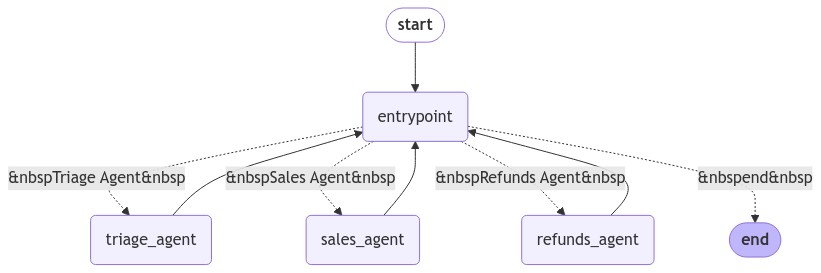

In [8]:
from langchain_core.messages import HumanMessage

triage_agent.handoffs = [sales_agent, refunds_agent]
# sales_agent.handoffs = transfer_back_to_triage
refunds_agent.functions = [process_refund, apply_discount]


wf = create_swarm_workflow(
    llm=ChatOpenAI(temperature=0.3, model_name="llama3.2:latest", openai_api_key="OPENAI_API_KEY", base_url="http://localhost:11434/v1"),
    entrypoint=triage_agent,
    with_user_agent=False,
    debug=False,
    # interrupt_after=["human_agent"],
)

import pprint
pprint.pprint(agent_map["Triage Agent"][1])
from IPython.display import display, Image
image = wf.get_graph().draw_mermaid_png()
display(Image(image))

In [61]:
def pretty_print(messages):
    for message in messages:
        print(message)
        
user_inputs = [
    "I need a refund",
    "Fine, it's done. and I want to talk to sales",
    "I want to talk to sales",    
    "/end",
]

resp = {"messages": [], "agent_name": triage_agent.name, "handoff": True}
user_inputs_index = 0
while True:
    # user_input = input("User: ")
    user_input = user_inputs[user_inputs_index]
    user_inputs_index += 1
    if user_input.strip() == "/end":
        break
    print(f"User Input[human]: {user_input}")
    messages = resp["messages"] + [HumanMessage(content=user_input, name="User")]
    current_agent = resp["agent_name"]
    resp = wf.invoke({"messages": messages, "agent_name": current_agent, "handoff": True})
    # pretty_print(resp["messages"])
    


==> entering:  Triage Agent
Triage Agent[ai]: content='' additional_kwargs={'tool_calls': [{'id': 'call_ersy47ip', 'function': {'arguments': '{}', 'name': 'refunds_agent'}, 'type': 'function'}], 'agent_name': 'Triage Agent'} response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 231, 'total_tokens': 245}, 'model_name': 'llama3.2:latest', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'tool_calls', 'logprobs': None} name='Triage Agent' id='run-0436a7d4-9010-4cf3-870b-9e5c3263c88a-0' tool_calls=[{'name': 'refunds_agent', 'args': {}, 'id': 'call_ersy47ip', 'type': 'tool_call'}]
Triage Agent[tool]: content='handoff to Refunds Agent' additional_kwargs={'agent_name': 'Triage Agent'} name='refunds_agent' id='abd2c258-58e8-4b98-b12d-0f7005de7398' tool_call_id='call_ersy47ip'
==> handoff to:  Refunds Agent
==> entering:  Refunds Agent
Refunds Agent[ai]: content="Refunds Agent: I'd be happy to help you with your refund request. Can you please provide me with some more 

In [10]:
# stream mode
user_inputs = [
    "I need a refund",
    "Fine, it's done. and I want to talk to sales",
    "I want to talk to sales",    
    "/end",
]
resp = {"messages": [], "agent_name": triage_agent.name, "handoff": True}
user_inputs_index = 0
# user_input = input("User: ")
user_input = user_inputs[user_inputs_index]
user_inputs_index += 1
# if user_input.strip() == "/end":
#     break
print(f"User Input[human]: {user_input}")
messages = resp["messages"] + [HumanMessage(content=user_input, name="User")]
current_agent = resp["agent_name"]
for resp in wf.stream(input={"messages": messages, "agent_name": current_agent, "handoff": True}):
    print(resp)


User Input[human]: I need a refund
==> entering:  Triage Agent
Triage Agent[ai]: content='' additional_kwargs={'tool_calls': [{'id': 'call_qpzki9lu', 'function': {'arguments': '{}', 'name': 'refunds_agent'}, 'type': 'function'}], 'agent_name': 'Triage Agent'} response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 231, 'total_tokens': 243}, 'model_name': 'llama3.2:latest', 'system_fingerprint': 'fp_ollama', 'finish_reason': 'tool_calls', 'logprobs': None} name='Triage Agent' id='run-0a46abf9-6e99-4238-ab39-67f689b85742-0' tool_calls=[{'name': 'refunds_agent', 'args': {}, 'id': 'call_qpzki9lu', 'type': 'tool_call'}]
Triage Agent[tool]: content='handoff to Refunds Agent' additional_kwargs={'agent_name': 'Triage Agent'} name='refunds_agent' id='fd4e521d-93ca-423a-aebb-605af41b38d5' tool_call_id='call_qpzki9lu'
==> handoff to:  Refunds Agent
{'triage_agent': {'messages': [HumanMessage(content='I need a refund', name='User', id='1a9699a1-e2d4-41e1-967c-46c10d186445'), A

---

In [ ]:
from langchain_core.messages import HumanMessage

triage_agent.handoffs = [sales_agent, refunds_agent]
# sales_agent.handoffs = transfer_back_to_triage
refunds_agent.functions = [process_refund, apply_discount]
# refunds_agent.handoffs = [transfer_back_to_triage]
def create_swarm_agent(llm , agent: Agent):
    tools = agent.functions.copy()
    # process handoffs
    for handoff in agent.handoffs:
        tools.append(create_swarm_handoff(handoff))
        if handoff.backlink:
            tools.append(create_swarm_backlink(agent))
        
    print("tools",tools)
    lc_agent = _create_swarm_agent(
        model=llm,
        tools=tools,
        messages_modifier=agent.instructions,
        debug=False
    )
    return lc_agent
llm = ChatOpenAI(temperature=0.3, model_name="llama3.2:latest", openai_api_key="OPENAI_API_KEY", base_url="http://localhost:11434/v1")
agent_map = {}
triage_agent_lc = create_swarm_agent(llm, triage_agent)
agent_map[triage_agent.name] = triage_agent_lc
sales_agent_lc = create_swarm_agent(llm, sales_agent)
agent_map[sales_agent.name] = sales_agent_lc
refunds_agent_lc = create_swarm_agent(llm, refunds_agent)
agent_map[refunds_agent.name] = refunds_agent_lc
    

def loop_agents(agent_name: str, inputs: str):
    messages = [HumanMessage(content=inputs)]
    agent = agent_map[agent_name]
    print(f"User: {inputs}")
    while True:
        init_len = len(messages)
        resp = agent.invoke(input={"messages": messages, "next_agent": None, "agent_name": agent_name})
        messages = resp["messages"]
        # end with response
        for message in messages[init_len:]:
            print(f"{agent_name}: {message}")
        next_agent = resp.get("next_agent", None)
        if next_agent is None:
            # wait for input
            user_input = input()
            if user_input.strip() == "/end":
                break
            print(f"User: {user_input}")
            messages.append(HumanMessage(content=user_input))
        else:
            # hand off
            agent = agent_map[next_agent]
            agent_name = next_agent
    
loop_agents(agent_name=triage_agent.name, inputs="I need a refund for item 111")

---

In [ ]:
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import BaseTool, tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage

llm = ChatOpenAI(temperature=0.3, model_name="llama3.2:latest", openai_api_key="OPENAI_API_KEY", base_url="http://localhost:11434/v1")

@tool
def process_refund():
    """
    Process a refund.
    
    Args:
        None
    """
    print("[mock] Processing refund...")
    return "Success!"

agent = create_react_agent(
    model=llm,
    tools=[process_refund],
    debug=True
)
messages = [HumanMessage(content="I need a refund")]
agent.invoke(input={"messages": messages})